In [1]:
import os
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [60]:
import requests
from pyspark.sql import Row

r=requests.get("https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json")
wc=r.json() #json으로 읽는다.
wcDf = spark.createDataFrame(Row(**x) for x in wc)

# S.5 DataFrame API 사용해보기

### range
- range(start, end=None, setp=1, numPartitions=None) 

In [2]:
spark.range(0, 10, 2).show()

+---+
| id|
+---+
|  0|
|  2|
|  4|
|  6|
|  8|
+---+



---

### 컬럼 추가 withColumn, 컬럼 삭제 Drop

In [3]:
tDf = spark\
    .read\
    .options(header='false', inferschema='true', delimiter='\t')\
    .csv(os.path.join('data', 'ds_spark_heightweight.txt'))

In [4]:
tDf.columns

['_c0', '_c1', '_c2']

In [5]:
#컬럼 추가
tDf = tDf.withColumn("id", tDf._c0.cast("integer"))
tDf = tDf.withColumn("height", tDf['_c1'].cast("double"))
tDf = tDf.withColumn("weight", tDf['_c2'].cast("double"))

In [6]:
#자동생성 컬럼
tDf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- id: integer (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)



In [7]:
#중복이있으니.. drop을시키자!
tDf = tDf.drop('_c0').drop('_c1').drop('_c2')

In [8]:
tDf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)



In [9]:
tDf.take(1)

[Row(id=1, height=65.78, weight=112.99)]

---

### 사용자정의 함수 udf
- DataFrame의 withColumn() 함수와 같이 사용되어 새로운 컬럼을만드는 경우 유용
- 보통 함수와 같이 함수명과 반환 값을 미리 정의해서 lambda 함수 또는 다른 함수를 사용할 수 있음
- 다른 함수를 직접 사용할 수 없고, udf()를 통해서 호출해야함
- udf()는 코드가 복잡한 경우에 함수를 분리해서 처리하면 유용

In [10]:
myDf = spark\
        .read.format('com.databricks.spark.csv')\
        .options(header='true', inferschema='true')\
        .load(os.path.join('data','myDf.csv'))

In [11]:
myDf.printSchema()
#c0 자동생성

root
 |-- _c0: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)



In [12]:
myDf.show()

+---+----+-------+------+
|_c0|year|   name|height|
+---+----+-------+------+
|  0|   1|kim, js|   170|
|  1|   1|lee, sm|   175|
|  2|   2|lim, yg|   180|
|  3|   2|    lee|   170|
+---+----+-------+------+



#### udf함수로 대문자 변환 withColumn

In [13]:
def uppercase(s):
    return s.upper()

In [14]:
uppercase("a")

'A'

In [15]:
# withColumn안에 함수를 바로 호출하면 오류!
#의도: name을 upper로 한 것을 컬럼에 추가하고 싶었음

myDf = myDf.withColumn("nameUpper", uppercase(myDf.name))
#저자리에 udf를 통해서 호출해야함!

TypeError: 'Column' object is not callable

In [16]:
from pyspark.sql.types import StringType #반환 모듈 선언
from pyspark.sql.functions import udf

upperUdf = udf(uppercase, StringType()) #반환 모듈 정의

In [17]:
myDf = myDf.withColumn("nameUpper", upperUdf(myDf['name']))

In [18]:
myDf.show()

+---+----+-------+------+---------+
|_c0|year|   name|height|nameUpper|
+---+----+-------+------+---------+
|  0|   1|kim, js|   170|  KIM, JS|
|  1|   1|lee, sm|   175|  LEE, SM|
|  2|   2|lim, yg|   180|  LIM, YG|
|  3|   2|    lee|   170|      LEE|
+---+----+-------+------+---------+



#### udf함수로 Double변환 withColumn

In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

toDoublefunc = udf(lambda x: float(x), DoubleType())
myDf = myDf.withColumn("heightD", toDoublefunc(myDf.height))

In [21]:
myDf.dtypes

[('_c0', 'int'),
 ('year', 'int'),
 ('name', 'string'),
 ('height', 'int'),
 ('nameUpper', 'string'),
 ('heightD', 'double')]

#### udf함수로 정수변환 withColumn

In [22]:
#from pyspark.sql.functions import udf, struct
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

toint=udf(lambda x:int(x), IntegerType())
myDf=myDf.withColumn("yearI", toint(myDf['year']))

In [23]:
myDf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- nameUpper: string (nullable = true)
 |-- heightD: double (nullable = true)
 |-- yearI: integer (nullable = true)



In [24]:
myDf.show()

+---+----+-------+------+---------+-------+-----+
|_c0|year|   name|height|nameUpper|heightD|yearI|
+---+----+-------+------+---------+-------+-----+
|  0|   1|kim, js|   170|  KIM, JS|  170.0|    1|
|  1|   1|lee, sm|   175|  LEE, SM|  175.0|    1|
|  2|   2|lim, yg|   180|  LIM, YG|  180.0|    2|
|  3|   2|    lee|   170|      LEE|  170.0|    2|
+---+----+-------+------+---------+-------+-----+



In [25]:
myDf.select('yearI').show()

+-----+
|yearI|
+-----+
|    1|
|    1|
|    2|
|    2|
+-----+



#### udf함수로 조건에 따른 withColumn

In [26]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

height_udf = udf(lambda height: "taller" if height >=175 else "shorter", StringType())
heightDf=myDf.withColumn("height>175", height_udf(myDf.heightD))

In [27]:
heightDf.show()

+---+----+-------+------+---------+-------+-----+----------+
|_c0|year|   name|height|nameUpper|heightD|yearI|height>175|
+---+----+-------+------+---------+-------+-----+----------+
|  0|   1|kim, js|   170|  KIM, JS|  170.0|    1|   shorter|
|  1|   1|lee, sm|   175|  LEE, SM|  175.0|    1|    taller|
|  2|   2|lim, yg|   180|  LIM, YG|  180.0|    2|    taller|
|  3|   2|    lee|   170|      LEE|  170.0|    2|   shorter|
+---+----+-------+------+---------+-------+-----+----------+



---

### 컬럼명 변경 withColumnRenamed

In [28]:
tDf=tDf.withColumnRenamed('id','ID')

In [29]:
tDf.show(3)

+---+------+------+
| ID|height|weight|
+---+------+------+
|  1| 65.78|112.99|
|  2| 71.52|136.49|
|  3|  69.4|153.03|
+---+------+------+
only showing top 3 rows



---

### 그래프
- Spark에는 그래프를 그리는 기능이 없다.
- Python matplotlib을 이용해서 그래프를 표현한다. 
    - 2차원 plot()을 하기 위해서는, x와 y축 값이 필요하다. 
- DataFrame -> RDD로 변환하고, map() 함수를 사용하여 배열로부터 weight, height를 분리해야 한다.
#### plot

In [30]:
_weightRdd=tDf.rdd.map(lambda fields:fields[1]).collect()
_heightRdd=tDf.rdd.map(lambda fields:fields[2]).collect()

In [31]:
import numpy as np
print (np.array(_weightRdd)[:5]) #0,1,2,3,4 / (0,5)랑 비슷
print (np.array(_heightRdd)[:5])

[65.78 71.52 69.4  68.22 67.79]
[112.99 136.49 153.03 142.34 144.3 ]


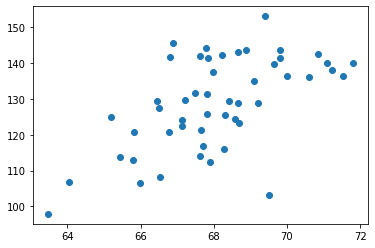

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.array(_weightRdd), np.array(_heightRdd),'o')
plt.show()

- 참조 https://kongdols-room.tistory.com/82

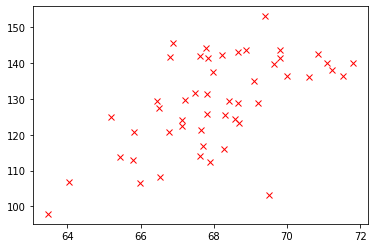

In [123]:
plt.plot(np.array(_weightRdd), np.array(_heightRdd),'rx')
plt.show()

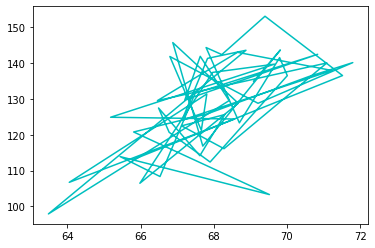

In [124]:
plt.plot(np.array(_weightRdd), np.array(_heightRdd),'c')
plt.show()

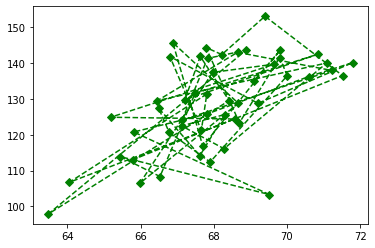

In [128]:
plt.plot(np.array(_weightRdd), np.array(_heightRdd),'gD--')
plt.show()

#### boxplot, violinplot

- boxplot은 최대, 최소값을 양 극단에 표현하고, 가운데 박스는 4분위 값의 2, 3번째와 50% 값을 보여준다.
- violin plot 역시 boxplot과 유사한 기능이지만, 밀도를 보여주고 있다.

In [33]:
height = tDf.select("height").toPandas()

In [132]:
height.describe()

,height
count,50.00000
mean,68.05240
std,1.82398
min,63.48000
25%,66.94000
50%,67.86500
75%,69.18000
max,71.80000


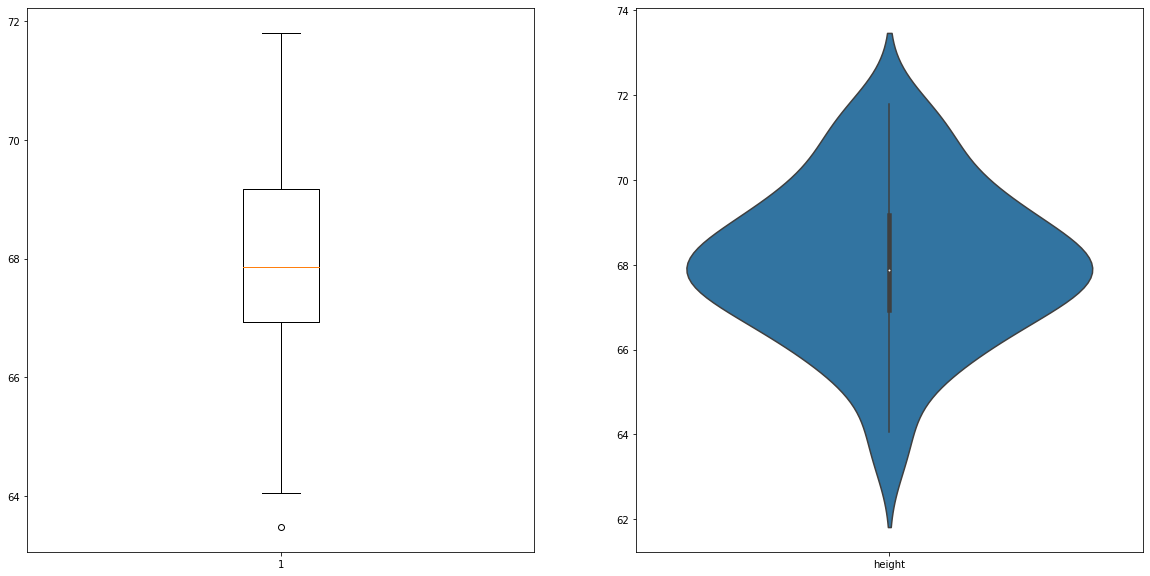

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns #그래프 라이브러리, matplot보다 그래프종류가 많음

fig = plt.figure(figsize=(20, 10)) 
ax1 = fig.add_subplot(1, 2, 1)  # subplot location #1: 행, 2: 열(컬럼) 1: 1번째에 배치
ax1 = plt.boxplot(height['height'])

ax2 = fig.add_subplot(1, 2, 2) #1: 행, 2: 열(컬럼) 1: 2번째에 배치
ax2 = sns.violinplot(data=height)

---

### 컬럼 조회 select

컬럼 선택|예제|권고
:---:|:---:|:---:|
점 연산자로 컬럼을 선택|myDf.name|N
인덱스로 컬럼을 선택|myDf['name']|Y

#### 컬럼명으로 직접 조회 못해

In [37]:
# 컬럼명만 적어주면 조회할 수 없다.
myDf['name']

Column<b'name'>

In [38]:
#컬럼 데이터를 조회하기 위해 컬럼에 show(), collect() 함수를 사용해서는 안된다
myDf['name'].show()

TypeError: 'Column' object is not callable

#### 컬럼 조회

In [39]:
_name=myDf.select('name') #선택 -> df로
_name.show()

+-------+
|   name|
+-------+
|kim, js|
|lee, sm|
|lim, yg|
|    lee|
+-------+



In [40]:
_name=myDf.select('name', 'height').show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|lee, sm|   175|
|lim, yg|   180|
|    lee|   170|
+-------+------+



In [41]:
cols = ['name', 'height']
myDf.select(*cols).show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|lee, sm|   175|
|lim, yg|   180|
|    lee|   170|
+-------+------+



#### select like

In [147]:
myDf.select("name", "height", myDf.name.like("%lee%")).show()
# %lee% : lee와 같은 data가 있는 경우 보여준다.
# %는 wild문자로써 문자가 있거나 없거나 상관없이 판단.
## "lee", "tlee", "lee," 다 true로..

+-------+------+---------------+
|   name|height|name LIKE %lee%|
+-------+------+---------------+
|kim, js|   170|          false|
|lee, sm|   175|           true|
|lim, yg|   180|          false|
|    lee|   170|           true|
+-------+------+---------------+



#### select startswith

In [43]:
#kim으로 시작하는...
myDf.select("name", "height", myDf.name.startswith("kim")).show()

+-------+------+---------------------+
|   name|height|startswith(name, kim)|
+-------+------+---------------------+
|kim, js|   170|                 true|
|lee, sm|   175|                false|
|lim, yg|   180|                false|
|    lee|   170|                false|
+-------+------+---------------------+



#### select endswith

In [44]:
#lee로 끝나는..
myDf.select("name", "height", myDf.name.endswith("lee")).show()

+-------+------+-------------------+
|   name|height|endswith(name, lee)|
+-------+------+-------------------+
|kim, js|   170|              false|
|lee, sm|   175|              false|
|lim, yg|   180|              false|
|    lee|   170|               true|
+-------+------+-------------------+



---

### alias

In [45]:
myDf1 = myDf.alias("myDf1")

In [46]:
#alias로 컬럼명을 정할수있다.
#name을 골라서, 하위 3개 뽑아서, 컬럼 이름 변경한다.

#sumbsr: 문자열 일부 추출

myDf1.select(myDf1.name.substr(1,3).alias("short name")).show(3)

+----------+
|short name|
+----------+
|       kim|
|       lee|
|       lim|
+----------+
only showing top 3 rows



#### 행과 열을 선택 select, when, otherwise

In [47]:
from pyspark.sql.functions import when
myDf.select("height", when(myDf.height < 175, 1).otherwise(0)).show()
#when: 조건문

+------+------------------------------------------+
|height|CASE WHEN (height < 175) THEN 1 ELSE 0 END|
+------+------------------------------------------+
|   170|                                         1|
|   175|                                         0|
|   180|                                         0|
|   170|                                         1|
+------+------------------------------------------+



In [48]:
from pyspark.sql.functions import when

#컬럼명 변경

myDf.select("height", (when(myDf.height < 175, 1).otherwise(0)).alias('<175')).show()

+------+----+
|height|<175|
+------+----+
|   170|   1|
|   175|   0|
|   180|   0|
|   170|   1|
+------+----+



In [49]:
from pyspark.sql.functions import when

#0,1이아니라 문자열로 

_myDf=myDf.select(when(myDf['heightD'] >175.0, ">175").otherwise("<175").alias("how tall"))

In [50]:
_myDf.show()

+--------+
|how tall|
+--------+
|    <175|
|    <175|
|    >175|
|    <175|
+--------+



withColumn() 함수를 사용하면, DataFrame에 컬럼을 추가하게 된다.

In [51]:
_myDf = myDf.withColumn('how tall', when(myDf['heightD'] >175.0, ">175").otherwise("<175"))
_myDf.show()

+---+----+-------+------+---------+-------+-----+--------+
|_c0|year|   name|height|nameUpper|heightD|yearI|how tall|
+---+----+-------+------+---------+-------+-----+--------+
|  0|   1|kim, js|   170|  KIM, JS|  170.0|    1|    <175|
|  1|   1|lee, sm|   175|  LEE, SM|  175.0|    1|    <175|
|  2|   2|lim, yg|   180|  LIM, YG|  180.0|    2|    >175|
|  3|   2|    lee|   170|      LEE|  170.0|    2|    <175|
+---+----+-------+------+---------+-------+-----+--------+



#### 행과 열을 선택 where, select

In [52]:
myDf.where(myDf['height'] < 175).show()

+---+----+-------+------+---------+-------+-----+
|_c0|year|   name|height|nameUpper|heightD|yearI|
+---+----+-------+------+---------+-------+-----+
|  0|   1|kim, js|   170|  KIM, JS|  170.0|    1|
|  3|   2|    lee|   170|      LEE|  170.0|    2|
+---+----+-------+------+---------+-------+-----+



In [53]:
myDf.where(myDf['height'] < 175)\
    .select(myDf['name'], myDf['height']).show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|    lee|   170|
+-------+------+



---

### filter
- where()과 유사

In [54]:
myDf.filter(myDf['height'] > 175).show()

+---+----+-------+------+---------+-------+-----+
|_c0|year|   name|height|nameUpper|heightD|yearI|
+---+----+-------+------+---------+-------+-----+
|  2|   2|lim, yg|   180|  LIM, YG|  180.0|    2|
+---+----+-------+------+---------+-------+-----+



---

### regexp_replace 컬럼의 내용 변경

In [55]:
from pyspark.sql.functions import *

_heightDf = myDf.withColumn('nameNew', regexp_replace('name', 'lee', 'lim'))
_heightDf.show()

+---+----+-------+------+---------+-------+-----+-------+
|_c0|year|   name|height|nameUpper|heightD|yearI|nameNew|
+---+----+-------+------+---------+-------+-----+-------+
|  0|   1|kim, js|   170|  KIM, JS|  170.0|    1|kim, js|
|  1|   1|lee, sm|   175|  LEE, SM|  175.0|    1|lim, sm|
|  2|   2|lim, yg|   180|  LIM, YG|  180.0|    2|lim, yg|
|  3|   2|    lee|   170|      LEE|  170.0|    2|    lim|
+---+----+-------+------+---------+-------+-----+-------+



---

### groupBy

In [56]:
myDf.groupby(myDf['year'])

#### groupBy하고 max

In [148]:
myDf.groupby(myDf['year']).max().show()

+----+--------+---------+-----------+------------+----------+
|year|max(_c0)|max(year)|max(height)|max(heightD)|max(yearI)|
+----+--------+---------+-----------+------------+----------+
|   1|       1|        1|        175|       175.0|         1|
|   2|       3|        2|        180|       180.0|         2|
+----+--------+---------+-----------+------------+----------+



#### groupBy, agg
- `agg()`는 합계 함수를 계산할 수 있으며, 지원하는 함수는 avg, max, min, sum, count
- dictionary 형식으로 key는 컬럼명, value는 합계 함수를 적어준다

In [58]:
myDf.groupBy('year').agg({"heightD":"avg"}).show()
# agg함수() 안에는 딕셔너리값 "컬럼":"함수"(여기선 평균내는거)

+----+------------+
|year|avg(heightD)|
+----+------------+
|   1|       172.5|
|   2|       175.0|
+----+------------+



#### groupBy 국가별 인원수 (1차원)

In [61]:
wcDf.groupBy(wcDf.ClubCountry).count().show()

+-----------+-----+
|ClubCountry|count|
+-----------+-----+
|   England |    4|
|   Paraguay|   93|
|     Russia|   51|
|        POL|   11|
|        BRA|   27|
|    Senegal|    1|
|     Sweden|  154|
|   Colombia|    1|
|        FRA|  155|
|        ALG|    8|
|   England |    1|
|       RUS |    1|
|     Turkey|   65|
|      Zaire|   22|
|       Iraq|   22|
|    Germany|  206|
|        RSA|   16|
|        ITA|  224|
|        UKR|   38|
|        GHA|    8|
+-----------+-----+
only showing top 20 rows



#### groupBy 국가별 포지션별 인원수 (2차원)

In [62]:
wcDf.groupBy('ClubCountry').pivot('Position').count().show()
# group을 2번할필요없이 pivot을 통해 열에 들어갈 이름 적음

#null값이 많다..

+-----------+----+----+----+----+----+
|ClubCountry|    |  DF|  FW|  GK|  MF|
+-----------+----+----+----+----+----+
|   England |null|null|   2|null|   2|
|   Paraguay|null|  26|  37|  10|  20|
|     Russia|null|  20|  11|   4|  16|
|        POL|null|   2|   2|   3|   4|
|        BRA|null|   7|   5|   4|  11|
|    Senegal|null|null|null|   1|null|
|     Sweden|null|  40|  47|  25|  42|
|   Colombia|null|null|   1|null|null|
|        ALG|null|   2|null|   6|null|
|        FRA|null|  46|  41|  18|  50|
|   England |null|null|null|null|   1|
|       RUS |null|null|null|   1|null|
|     Turkey|null|  20|  13|  12|  20|
|      Zaire|null|   6|   5|   3|   8|
|       Iraq|null|   6|   4|   3|   9|
|    Germany|null|  64|  51|  16|  75|
|        RSA|null|   5|   2|   3|   6|
|        UKR|null|  13|   7|   4|  14|
|        ITA|null|  74|  42|  19|  89|
|        CMR|null|   1|   1|   1|null|
+-----------+----+----+----+----+----+
only showing top 20 rows



---

### F 함수
- pyspark.sql.functions은 함수이므로, `from pyspark.sql.functions import split` 이렇게 한다. 또는 `from pyspark.sql import functions as F`라고 한다.

In [63]:
from pyspark.sql import functions as F

myDf.agg(F.min(myDf.heightD),F.max(myDf.heightD),F.avg(myDf.heightD),F.sum(myDf.heightD)).show()

+------------+------------+------------+------------+
|min(heightD)|max(heightD)|avg(heightD)|sum(heightD)|
+------------+------------+------------+------------+
|       170.0|       180.0|      173.75|       695.0|
+------------+------------+------------+------------+



---

### 행 추가 (수업은 안하심)

In [88]:
_myDf = spark\
        .read.format('com.databricks.spark.csv')\
        .options(header='true', inferschema='true')\
        .load(os.path.join('data','myDf.csv'))

In [89]:
_myDf.show()

+---+----+-------+------+
|_c0|year|   name|height|
+---+----+-------+------+
|  0|   1|kim, js|   170|
|  1|   1|lee, sm|   175|
|  2|   2|lim, yg|   180|
|  3|   2|    lee|   170|
+---+----+-------+------+



In [90]:
toAppendDf = spark.createDataFrame([Row(4, 1, "choi, js", 177)])

In [91]:
_myDf = _myDf.union(toAppendDf)

In [92]:
_myDf.show()

+---+----+--------+------+
|_c0|year|    name|height|
+---+----+--------+------+
|  0|   1| kim, js|   170|
|  1|   1| lee, sm|   175|
|  2|   2| lim, yg|   180|
|  3|   2|     lee|   170|
|  4|   1|choi, js|   177|
+---+----+--------+------+



---

### partition

#### partition 개수

In [158]:
_myDf.rdd.getNumPartitions()

1

#### repartition
- 파티션을 늘리거나 줄이거나 재설정

In [159]:
_myDf2 = _myDf.repartition(4)
print(_myDf2.rdd.getNumPartitions())

4


#### coalesce
- 파티션을 줄일때만 사용

In [160]:
_myDf2 = _myDf.coalesce(2)
print(_myDf2.rdd.getNumPartitions())

2


---

### 통계 요약 describe
- column이 연산가능한 데이터타잎인 경우, 요약 값을 볼 수 있다.

In [96]:
_myDf.describe().show()

+-------+------------------+------------------+--------+----------------+
|summary|               _c0|              year|    name|          height|
+-------+------------------+------------------+--------+----------------+
|  count|                 5|                 5|       5|               5|
|   mean|               2.0|               1.4|    null|           174.4|
| stddev|1.5811388300841898|0.5477225575051661|    null|4.39317652729776|
|    min|                 0|                 1|choi, js|             170|
|    max|                 4|                 2| lim, yg|             180|
+-------+------------------+------------------+--------+----------------+



---

### 결측값 
- 평균값 낼 때 영향 미친다!  


결측값 없애기
- `df.na.fill(0)` 모든 컬럼의 na를 0으로 교체
- `df.fillna( { 'c0':0, 'c1':0 } )` 컬럼 c0, c1의 na를 0으로 교체

결측값 삭제
- `df.na.drop(subset=["c0"])`


In [97]:
from pyspark.sql import functions as F
myDf.where(F.col("height").isNull()) #해당사항 없어서 출력X

DataFrame[_c0: int, year: int, name: string, height: int, nameUpper: string, heightD: double, yearI: int]

In [98]:
from pyspark.sql.functions import isnan, when, count, col
myDf.select([count(when(isnan(c), c)).alias(c) for c in myDf.columns]).show()

+---+----+----+------+---------+-------+-----+
|_c0|year|name|height|nameUpper|heightD|yearI|
+---+----+----+------+---------+-------+-----+
|  0|   0|   0|     0|        0|      0|    0|
+---+----+----+------+---------+-------+-----+



- nan: not a number
- Null값과 약간 다름

In [99]:
from pyspark.sql.functions import isnan, when, count, col
myDf.select([count(when(col(c).isNull(), c)).alias(c) for c in myDf.columns]).show()

+---+----+----+------+---------+-------+-----+
|_c0|year|name|height|nameUpper|heightD|yearI|
+---+----+----+------+---------+-------+-----+
|  0|   0|   0|     0|        0|      0|    0|
+---+----+----+------+---------+-------+-----+



---

---